In [1]:
!pip install scorch

In [2]:
conda install -c conda-forge skorch

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.2
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - skorch


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    joblib-1.2.0               |     pyhd8ed1ab_0         205 KB  conda-forge
    scikit-learn-0.24.2        |   py39h4dfa638_0         7.6 MB  conda-forge
    scipy-1.6.3                |   py39hee8e79c_0        20.7 MB  conda-forge
    skorch-0.9.0               |     pyh7b7c402_0          93 KB  conda-forge
    tabulate-0.9.0             |     pyhd8ed1ab_1          35 KB  conda-forge
    threadpoolct

In [3]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.utils import compute_class_weight
import time
import torch
import torch.nn as nn
import random
from sklearn. metrics import f1_score, roc_curve, roc_auc_score
import scorch
from skorch import NeuralNetBinaryClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, recall_score, precision_score, precision_recall_curve

## Подключитесь к базе. Загрузите таблицы sql

In [4]:
db_config = {
    'user': 'praktikum_student', 
    # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', 
    # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, 
    # порт подключения,
    'db': 'data-science-vehicle-db' 
    # название базы данных,
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
# создание подключения
engine = create_engine(connection_string) 

### Вывод

Подключение к базе выполнено успешно.

## Проведите первичное исследование таблиц

### Таблица vehicles

In [5]:
# проверка работы запроса
query1 = '''
SELECT *
FROM vehicles;
'''
# выведем первую таблицу
sample_df1 = pd.read_sql_query(query1, con=engine) 
display(sample_df1.head(3))
# выведем общую информацию
display(sample_df1.info())

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


None

In [6]:
# выведем информацию о наличии пропусков
display(sample_df1.isnull().sum())

id                          0
case_id                     0
party_number                0
vehicle_type                0
vehicle_transmission    23659
vehicle_age             24582
dtype: int64

### Таблица collisions

In [7]:
# проверка работы запроса
query2 = '''
SELECT *
FROM collisions;
'''
# выведем вторую таблицу
sample_df2 = pd.read_sql_query(query2, con=engine) 
display(sample_df2.head(3))
# выведем общую информацию
display(sample_df2.info())

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

None

In [8]:
# выведем информацию о наличии пропусков
display(sample_df2.isnull().sum())

case_id                             0
county_city_location                0
county_location                     0
distance                            0
direction                      340642
intersection                    12219
weather_1                        7259
location_type                  881221
collision_damage                    0
party_count                         0
primary_collision_factor         8166
pcf_violation_category          27954
type_of_collision               11824
motor_vehicle_involved_with      6819
road_surface                    13093
road_condition_1                11988
lighting                         8593
control_device                   8407
collision_date                      0
collision_time                  12308
dtype: int64

### Таблица parties

In [9]:
# проверка работы запроса
query3 = '''
SELECT *
FROM parties
LIMIT 2000000;
'''
# выведем третью таблицу
sample_df3 = pd.read_sql_query(query3, con=engine) 
display(sample_df3.head(3))
# выведем общую информацию
display(sample_df3.info())

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 137.3+ MB


None

In [10]:
# выведем информацию о наличии пропусков
display(sample_df3.isnull().sum())

id                           0
case_id                      0
party_number                 0
party_type                3622
at_fault                     0
insurance_premium       340199
party_sobriety           61385
party_drug_physical    1649995
cellphone_in_use        404458
dtype: int64

### Таблица case_ids

In [11]:
# проверка работы запроса
query4 = '''
SELECT *
FROM case_ids;
'''
# выведем четвертую таблицу
sample_df4 = pd.read_sql_query(query4, con=engine) 
display(sample_df4.head(3))
# выведем общую информацию
display(sample_df4.info())

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


None

In [12]:
# выведем информацию о наличии пропусков
display(sample_df4.isnull().sum())

case_id    0
db_year    0
dtype: int64

### Вывод

- Все четыре таблицы, для выполнения задания - доступны. 
- Таблица `parties` не открывается если не ограничить выдачу результатов. Без ограничения, ломается ядро jupiter.
- В таблицах `vehicles`, `collisions` и `parties` имеются пропуски, но в таблице `case_ids` пропуски отсутсвуют.
- Для связи все таблицы имеют общий ключ `case_id`.

##  Проведите статистический анализ факторов ДТП

### Определение месяца с наибольшим количеством аварий

In [13]:
# сформируем запрос
query_3_col = '''
SELECT EXTRACT(MONTH FROM c.collision_date) AS month,
       COUNT(c.case_id) AS cnt
FROM collisions AS c
GROUP BY EXTRACT(MONTH FROM c.collision_date);
'''
# выведем как таблицу
df_3_col = pd.read_sql_query(query_3_col, con=engine) 
display(df_3_col)

,month,cnt
0,1.0,132044
1,2.0,128858
2,3.0,139581
3,4.0,130180
4,5.0,130316
5,6.0,102594
6,7.0,102227
7,8.0,104089
8,9.0,105159
9,10.0,112237


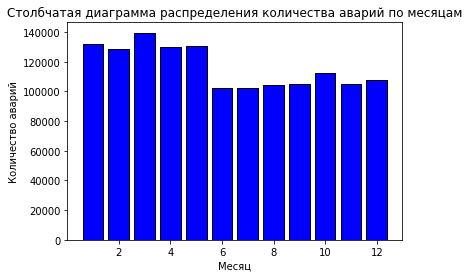

In [14]:
# построение стобчатого графика 
plt.bar(x = df_3_col.month, height = df_3_col.cnt, color = 'blue', edgecolor = 'black');
plt.title('Столбчатая диаграмма распределения количества аварий по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий');

#### Вывод

- Месяц с наибольшим количеством аварий - `март`, общее количество `139 581`.
    Скорее всего связано с гололедом и частым переходом температуры из положительной в отрицательную. 
- Месяц с наименьшим количеством аварий - `июль`, общее количество `102 227`.
    Скорее всего связано с оттоком людей в отпуска и как следствие меньше машин - меньше аварий.

### Задачи для коллег (совещание)

1. Провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП
2. Найти среднюю сумму страховки для всех типов повреждений
3. Провести анализ серьёзности повреждений транспортного средства, исходя из погодных условий в момент ДТП
4. Провести анализ серьёзности повреждений транспортного средства, исходя из возраста автомобиля в момент ДТП
5. Найти пять регионов с самым большим количеством ДТП 
6. Найти самые частые причины ДТП
7. найти самый частый тип кузова, участвующий в ДТП

### Решение для задачи №1

Провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП

In [15]:
# сформируем запрос
query_3_1 = '''
SELECT *,
       SUM(cnt) OVER (PARTITION BY road_surface) AS cnt_total
FROM 
    (SELECT c.road_surface,
           c.collision_damage AS col_dam,
           COUNT(p.case_id) AS cnt
    FROM collisions AS c
    JOIN parties AS p ON c.case_id = p.case_id
     GROUP BY c.road_surface,
              c.collision_damage
     ORDER BY road_surface) AS temp
'''
# выведем как таблицу
df_3_1 = pd.read_sql_query(query_3_1, con=engine) 
# display(df_3_1.head(30))

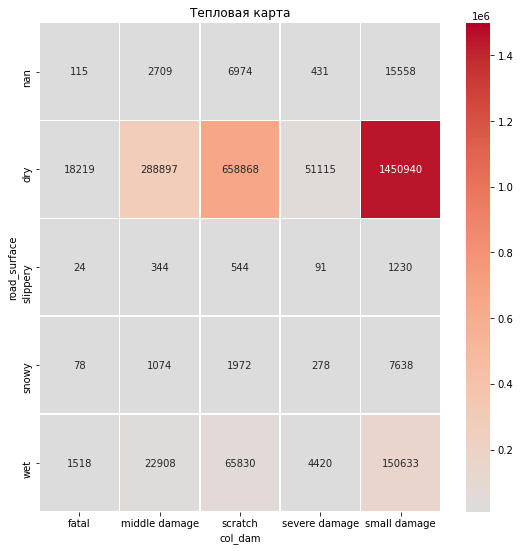

In [16]:
# создадим сводную таблицу для построения хитмап
rr1 = df_3_1.pivot('road_surface', 'col_dam', 'cnt')
# строим хитмэп
plt.figure(figsize=(9, 9)) # задаём размер графика
sns.heatmap(rr1, # датафрейм с данными
            linewidths=.5, # добавляем линии
            annot=True, # добавляем подписи
            fmt='', # задаём исходный формат
            cmap= 'coolwarm', # цветовая тема
            center=10000, vmin=10000, vmax=1500000) # параметры отрисовки
plt.title('Тепловая карта') # название графика
plt.show() 

#### Вывод

Зависимость степени повреждений от состояния покрытия выявила следующие закономерности:
- Покрытие типа `dry` имеет самые высокие показатели количества повреждений
- Самое частое повреждение это `small_damage` на покрытии дороги типа `dry`
- Самое редкое повреждение `fatal` на любом виде покрытия, но реже всего на покрытии `slippery`
- Покрытие дороги с самыми минимальными показателями повреждений соответствует типу `slippery`

### Решение для задачи №2

Найти среднюю сумму страховки для всех типов повреждений

In [17]:
# сформируем запрос
query_3_2 = '''
SELECT col_dam,
       ROUND(sum_prem/cnt, 2) AS mean_prem
FROM
(SELECT c.collision_damage AS col_dam,
       COUNT(p.case_id) AS cnt,
       SUM(p.insurance_premium) AS sum_prem 
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
GROUP BY c.collision_damage) AS temp;
'''
# выведем как таблицу
df_3_2 = pd.read_sql_query(query_3_2, con=engine) 
display(df_3_2.head(10))

,col_dam,mean_prem
0,fatal,39.0
1,middle damage,34.0
2,scratch,36.0
3,severe damage,35.0
4,small damage,30.0


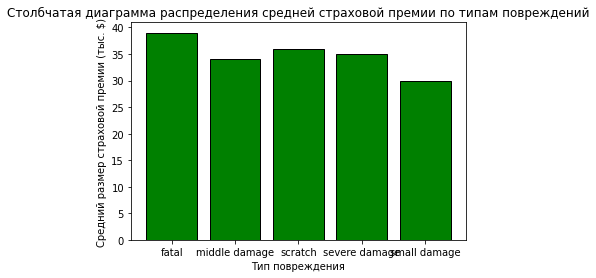

In [18]:
# построение стобчатого графика 
plt.bar(x = df_3_2.col_dam, height = df_3_2.mean_prem, color = 'green', edgecolor = 'black');
plt.title('Столбчатая диаграмма распределения средней страховой премии по типам повреждений')
plt.xlabel('Тип повреждения')
plt.ylabel('Средний размер страховой премии (тыс. $)');

#### Вывод

- Из предыдущей задачи известно, что количество поврждений отличается друг от друга многократно, здесь же можно сделать вывод, что стоимость страховки в среднем составляет около 37 тыс. $, вне зависимости от типа повреждений. 
- Тип повреждения `fatal` в среднем самый дорогой, что и не удивительно. Но стоимость премии за `царапину` в среднем выше чем за `small damage`.

## Создайте модель для оценки водительского риска

### Шаг 1 (Предварительная подготовка набора данных на основе предположения заказчика)

In [19]:
# сформируем запрос
query_4_col = '''
SELECT *
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
JOIN vehicles AS v ON c.case_id = v.case_id
WHERE c.collision_damage != 'scratch'
      AND EXTRACT(YEAR FROM c.collision_date) = 2012
'''
# выведем как таблицу
pd.set_option('display.max_columns', None)
df_4 = pd.read_sql_query(query_4_col, con=engine) 
display(df_4.head(3))

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,5403242,5400,tulare,2640.0,north,0.0,clear,None,fatal,2,vehicle code violation,improper turning,hit object,fixed object,dry,normal,daylight,none,2012-01-07,None,2312905,5403242,2,road bumper,0,NaN,None,None,NaN,1275239,5403242,1,coupe,manual,7.0
1,5403299,1942,los angeles,549.0,east,0.0,clear,None,fatal,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with street lights,functioning,2012-01-10,17:30:00,2313004,5403299,2,road signs,1,48.0,"had been drinking, under influence",under drug influence,0.0,1275335,5403299,1,sedan,manual,4.0
2,5403299,1942,los angeles,549.0,east,0.0,clear,None,fatal,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with street lights,functioning,2012-01-10,17:30:00,2313004,5403299,2,road signs,1,48.0,"had been drinking, under influence",under drug influence,0.0,1275336,5403299,2,hatchback,manual,7.0


### Шаг 2 (Первичный отбор факторов, необходимых для модели)

In [20]:
# удалим ненужные столбцы
df_4 = df_4.drop(['case_id', 'county_location', 'distance', 'intersection', 'collision_damage', 'party_count', 
           'primary_collision_factor', 'pcf_violation_category', 'type_of_collision', 
           'motor_vehicle_involved_with', 'collision_date', 'collision_time', 'id', 
           'case_id', 'party_number', 'party_type', 'id', 'case_id', 'party_number'], axis= 1)
display(df_4.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131460 entries, 0 to 131459
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   county_city_location  131460 non-null  object 
 1   direction             99086 non-null   object 
 2   weather_1             130987 non-null  object 
 3   location_type         56814 non-null   object 
 4   road_surface          130537 non-null  object 
 5   road_condition_1      130759 non-null  object 
 6   lighting              131023 non-null  object 
 7   control_device        130927 non-null  object 
 8   at_fault              131460 non-null  int64  
 9   insurance_premium     121419 non-null  float64
 10  party_sobriety        128729 non-null  object 
 11  party_drug_physical   13366 non-null   object 
 12  cellphone_in_use      115749 non-null  float64
 13  vehicle_type          131460 non-null  object 
 14  vehicle_transmission  129202 non-null  object 
 15  

None

In [21]:
# выведем информацию о наличии пропусков
display(df_4.isnull().sum())

county_city_location         0
direction                32374
weather_1                  473
location_type            74646
road_surface               923
road_condition_1           701
lighting                   437
control_device             533
at_fault                     0
insurance_premium        10041
party_sobriety            2731
party_drug_physical     118094
cellphone_in_use         15711
vehicle_type                 0
vehicle_transmission      2258
vehicle_age               3680
dtype: int64

#### Вывод

Причины удаления столбцов:
- Не характеризуют причину или риск аварии такие столбцы как `case_id`, `collision_date`, `collision_time`, `id`.
- Для столбца `county_location` уже имеется аналогичный столбец с числовыми значениями.
- Столбцы, которые описывают уже сам факт ДТП такие как `party_number`, `party_type`, `collision_damage`, `party_count`, `primary_collision_factor`, `pcf_violation_category`, `type_of_collision`, `distance`, `intersection`.
- Применен фильтр по данному столбцу `motor_vehicle_involved_with` в первичном запросе.

### Шаг 3 (Подготовка данных)

#### Заполнение пропусков, удаление дубликатов и приведение типа данных

In [22]:
# заполнение отсутствующих данных в столбце `direction`
df_4['direction'] = df_4['direction'].fillna('unknown')
# заполнение отсутствующих данных в столбце `weather_1`
df_4['weather_1'] = df_4['weather_1'].fillna('unknown')
# заполнение отсутствующих данных в столбце `location_type`
df_4['location_type'] = df_4['location_type'].fillna('unknown')
# заполнение отсутствующих данных в столбце `road_surface`
df_4['road_surface'] = df_4['road_surface'].fillna('unknown')
# заполнение отсутствующих данных в столбце `road_condition_1`
df_4['road_condition_1'] = df_4['road_condition_1'].fillna('unknown')
# заполнение отсутствующих данных в столбце `lighting`
df_4['lighting'] = df_4['lighting'].fillna('unknown')
# заполнение отсутствующих данных в столбце `control_device`
df_4['control_device'] = df_4['control_device'].fillna('none')
# расчет медианного значения для столбца `insurance_premium`
prem_med = df_4['insurance_premium'].median()
# заполнение отсутствующих данных в столбце `insurance_premium`
df_4['insurance_premium'] = df_4['insurance_premium'].fillna(prem_med)
# заполнение отсутствующих данных в столбце `party_sobriety`
df_4['party_sobriety'] = df_4['party_sobriety'].fillna('not applicable')
# заполнение отсутствующих данных в столбце `party_drug_physical`
df_4['party_drug_physical'] = df_4['party_drug_physical'].fillna('unknown')
# заполнение отсутствующих данных в столбце `cellphone_in_use`
df_4['cellphone_in_use'] = df_4['cellphone_in_use'].fillna(0)
# заполнение отсутствующих данных в столбце `vehicle_transmission`
df_4['vehicle_transmission'] = df_4['vehicle_transmission'].fillna('manual')
# расчет медианного значения для столбца `vehicle_age`
age_med = df_4['vehicle_age'].median()
# заполнение отсутствующих данных в столбце `vehicle_age`
df_4['vehicle_age'] = df_4['vehicle_age'].fillna(age_med)

# выведем информацию о наличии пропусков
display(df_4.isnull().sum())

county_city_location    0
direction               0
weather_1               0
location_type           0
road_surface            0
road_condition_1        0
lighting                0
control_device          0
at_fault                0
insurance_premium       0
party_sobriety          0
party_drug_physical     0
cellphone_in_use        0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
dtype: int64

In [ ]:
# изменение типа данных
df_4['county_city_location'] = df_4['county_city_location'].astype('int')
# удалим дублирующиеся данные в таблице
df_4 = df_4.drop_duplicates()
df_4.info()

#### Подготовка выборок

In [24]:
# создадим копию таблицы
new_df = df_4.copy()
# обозначим признаки и цели
features = new_df.drop('at_fault', axis=1)
target = new_df['at_fault']
# разделим на выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle=True, random_state=571)
# выведем размерности выборок на экран
display(f'X_train: {X_train.shape}')
display(f'X_test: {X_test.shape}')
display(f'y_train: {y_train.shape}')
display(f'y_test: {y_test.shape}')

'X_train: (87772, 15)'

'X_test: (37617, 15)'

'y_train: (87772,)'

'y_test: (37617,)'

#### Масштабирование признаков

In [25]:
# обозначим категориальные и количественные признаки
categorical = ['direction', 'weather_1', 'location_type', 'road_surface', 
               'road_condition_1', 'lighting', 'control_device', 'party_sobriety', 
               'party_drug_physical', 'cellphone_in_use', 'vehicle_type', 'vehicle_transmission']
numeric = ['county_city_location', 'insurance_premium', 'vehicle_age']

In [26]:
# уберем предупреждения
warnings.filterwarnings('ignore')
# используем scaler для преобразования числовых данных
scaler = StandardScaler()  
scaler.fit(X_train[numeric]) 
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
display(X_train.head(3))
display(X_test.head(3))

,county_city_location,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
42636,0.593267,south,clear,unknown,dry,normal,daylight,none,-1.009503,had not been drinking,unknown,0.0,sedan,auto,1.536495
31622,2.161716,unknown,clear,unknown,dry,normal,daylight,functioning,2.071541,had not been drinking,unknown,0.0,sedan,auto,1.536495
50346,-0.733942,west,cloudy,unknown,wet,normal,dark with street lights,none,-1.194365,"had been drinking, under influence",under drug influence,0.0,hatchback,manual,-0.587643


,county_city_location,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
54604,2.160935,unknown,clear,unknown,dry,normal,daylight,functioning,-0.886261,had not been drinking,unknown,0.0,sedan,auto,-0.284195
88359,-0.733942,unknown,cloudy,unknown,dry,normal,daylight,functioning,-1.255986,had not been drinking,unknown,0.0,coupe,manual,-0.891092
131160,0.593267,south,clear,highway,dry,normal,daylight,none,-0.639777,had not been drinking,unknown,0.0,sedan,auto,-1.497988


#### Категоризируем признаки

In [27]:
# используем ohe для преобразования категориальных данных
ohe = OneHotEncoder(handle_unknown='error') 
# преобразуем обучающую выборку
X_train_cop = X_train.copy()
X_train_cop = X_train_cop.reset_index(drop=True)
transformed_train = ohe.fit_transform(X_train_cop[categorical])
transformed_train = pd.DataFrame(transformed_train.toarray(), columns =(list(ohe.categories_[0])+
                                                                        list(ohe.categories_[1])+
                                                                        list(ohe.categories_[2])+
                                                                        list(ohe.categories_[3])+
                                                                        list(ohe.categories_[4])+
                                                                        list(ohe.categories_[5])+
                                                                        list(ohe.categories_[6])+
                                                                        list(ohe.categories_[7])+
                                                                        list(ohe.categories_[8])+
                                                                        list(ohe.categories_[9])+
                                                                        list(ohe.categories_[10])+
                                                                        list(ohe.categories_[11])))
X_train_new = X_train_cop.join(transformed_train, rsuffix='_right')
X_train_new = X_train_new.drop(categorical, axis=1)
X_train_new.columns = ['county_city_location', 'insurance_premium', 'vehicle_age', 'dir_east', 'dir_north', 'dir_south', 
                       'dir_unknown', 'dir_west', 'w_clear','w_cloudy', 'w_fog', 'w_other', 'w_raining', 'w_snowing', 
                       'w_unknown', 'w_wind', 'loctype_highway', 'loctype_intersection', 'loctype_ramp', 'loctype_unknown',
                       'r_surf_dry', 'r_surf_slippery', 'r_surf_snowy', 'r_surf_unknown', 'r_surf_wet', 'r_con_construction',
                       'r_con_flooded', 'r_con_holes', 'r_con_loose_material', 'r_con_normal', 'r_con_obstruction', 
                       'r_con_other', 'r_con_reduced_width', 'r_con_unknown', 'light_dark_no_lights', 'light_dark_with_lights', 
                       'light_dark_not_func_lights', 'light_daylight','light_dusk_dawn', 'light_unknown', 'con_dev_func', 
                       'con_dev_none', 'con_dev_not_func', 'con_dev_obs', 'sobr_diu', 'sobr_dnui', 'sobr_dui', 'sobr_nd',
                       'sobr_iu', 'sobr_na', 'drug_G', 'drug_F', 'drug_H', 'drug_I', 'drug_E', 'drug_unknown', 'cell_0',
                       'cell_1', 'vehicle_type_coupe', 'vehicle_type_hatchback', 'vehicle_type_minivan', 'vehicle_type_other',
                       'vehicle_type_sedan', 'transmission_auto', 'transmission_manual']
X_train_new = X_train_new.set_index(X_train.index)
display(X_train_new.head(3))
display(f'X_train_new: {X_train_new.shape}')

,county_city_location,insurance_premium,vehicle_age,dir_east,dir_north,dir_south,dir_unknown,dir_west,w_clear,w_cloudy,w_fog,w_other,w_raining,w_snowing,w_unknown,w_wind,loctype_highway,loctype_intersection,loctype_ramp,loctype_unknown,r_surf_dry,r_surf_slippery,r_surf_snowy,r_surf_unknown,r_surf_wet,r_con_construction,r_con_flooded,r_con_holes,r_con_loose_material,r_con_normal,r_con_obstruction,r_con_other,r_con_reduced_width,r_con_unknown,light_dark_no_lights,light_dark_with_lights,light_dark_not_func_lights,light_daylight,light_dusk_dawn,light_unknown,con_dev_func,con_dev_none,con_dev_not_func,con_dev_obs,sobr_diu,sobr_dnui,sobr_dui,sobr_nd,sobr_iu,sobr_na,drug_G,drug_F,drug_H,drug_I,drug_E,drug_unknown,cell_0,cell_1,vehicle_type_coupe,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,transmission_auto,transmission_manual
42636,0.593267,-1.009503,1.536495,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
31622,2.161716,2.071541,1.536495,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
50346,-0.733942,-1.194365,-0.587643,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


'X_train_new: (87772, 65)'

In [28]:
# преобразуем тестовую выборку
X_test_cop = X_test.copy()
X_test_cop = X_test_cop.reset_index(drop=True)
transformed_test = ohe.transform(X_test_cop[categorical])
transformed_test = pd.DataFrame(transformed_test.toarray(), columns =(list(ohe.categories_[0])+
                                                                        list(ohe.categories_[1])+
                                                                        list(ohe.categories_[2])+
                                                                        list(ohe.categories_[3])+
                                                                        list(ohe.categories_[4])+
                                                                        list(ohe.categories_[5])+
                                                                        list(ohe.categories_[6])+
                                                                        list(ohe.categories_[7])+
                                                                        list(ohe.categories_[8])+
                                                                        list(ohe.categories_[9])+
                                                                        list(ohe.categories_[10])+
                                                                        list(ohe.categories_[11])))
X_test_new = X_test_cop.join(transformed_test, rsuffix='_right')
X_test_new = X_test_new.drop(categorical, axis=1)
X_test_new.columns = ['county_city_location', 'insurance_premium', 'vehicle_age', 'dir_east', 'dir_north', 'dir_south', 
                       'dir_unknown', 'dir_west', 'w_clear','w_cloudy', 'w_fog', 'w_other', 'w_raining', 'w_snowing', 
                       'w_unknown', 'w_wind', 'loctype_highway', 'loctype_intersection', 'loctype_ramp', 'loctype_unknown',
                       'r_surf_dry', 'r_surf_slippery', 'r_surf_snowy', 'r_surf_unknown', 'r_surf_wet', 'r_con_construction',
                       'r_con_flooded', 'r_con_holes', 'r_con_loose_material', 'r_con_normal', 'r_con_obstruction', 
                       'r_con_other', 'r_con_reduced_width', 'r_con_unknown', 'light_dark_no_lights', 'light_dark_with_lights', 
                       'light_dark_not_func_lights', 'light_daylight','light_dusk_dawn', 'light_unknown', 'con_dev_func', 
                       'con_dev_none', 'con_dev_not_func', 'con_dev_obs', 'sobr_diu', 'sobr_dnui', 'sobr_dui', 'sobr_nd',
                       'sobr_iu', 'sobr_na', 'drug_G', 'drug_F', 'drug_H', 'drug_I', 'drug_E', 'drug_unknown', 'cell_0',
                       'cell_1', 'vehicle_type_coupe', 'vehicle_type_hatchback', 'vehicle_type_minivan', 'vehicle_type_other',
                       'vehicle_type_sedan', 'transmission_auto', 'transmission_manual']
X_test_new = X_test_new.set_index(X_test.index)
display(X_test_new.head(3))
display(f'X_test_new: {X_test_new.shape}')

,county_city_location,insurance_premium,vehicle_age,dir_east,dir_north,dir_south,dir_unknown,dir_west,w_clear,w_cloudy,w_fog,w_other,w_raining,w_snowing,w_unknown,w_wind,loctype_highway,loctype_intersection,loctype_ramp,loctype_unknown,r_surf_dry,r_surf_slippery,r_surf_snowy,r_surf_unknown,r_surf_wet,r_con_construction,r_con_flooded,r_con_holes,r_con_loose_material,r_con_normal,r_con_obstruction,r_con_other,r_con_reduced_width,r_con_unknown,light_dark_no_lights,light_dark_with_lights,light_dark_not_func_lights,light_daylight,light_dusk_dawn,light_unknown,con_dev_func,con_dev_none,con_dev_not_func,con_dev_obs,sobr_diu,sobr_dnui,sobr_dui,sobr_nd,sobr_iu,sobr_na,drug_G,drug_F,drug_H,drug_I,drug_E,drug_unknown,cell_0,cell_1,vehicle_type_coupe,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,transmission_auto,transmission_manual
54604,2.160935,-0.886261,-0.284195,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
88359,-0.733942,-1.255986,-0.891092,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
131160,0.593267,-0.639777,-1.497988,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


'X_test_new: (37617, 65)'

#### Вывод

1. В процессе подготовки данных были заполнены пропуски: 
- Заглушкой `unknown`, либо наиболее подходящим значением в сторону наибольшей группы категорий, например `none`, `not applicable`, `0` или `manual`. 
- В данных, имеющие тип `float`, заполнены медианой.
2. Удалены дублирующиеся строки.
3. Выборки разделены на обучающую и тестовую в соотношении 70/30.
4. Проведены категоризация признаков методом OHE.
5. Проведено масштабирование признаков с помощью StandardScaler.

### Выбор метрики

При рассмотрении `Precision`, `Recall` и `F1` меры, выбор пал именно на последнюю. Так как `Recall` описывает, как хорошо модель разобралась в особенностях класса и распознала его, а `Precision` выявляет, не преувеличивает ли модель, присваивая положительные метки. Поэтому оптимальным решением будет выбор `F1` меры, как средне гармонического между `Precision` и `Recall`. 

## Проведите анализ важности факторов ДТП

### Модель LogisticRegression

In [29]:
%%time
start_0 = time.time()
### обучим модель LogisticRegression с помощью GridSearchCV для расчета f1 меры
# параметры по сетке
parameters_0 = {
    'max_iter': [5000, 10000], 
    'C': [1e3, 1e4],
    'solver': ['newton-cg', 'lbfgs'] 
}
log_reg0 = LogisticRegression(random_state=42, class_weight='balanced')
clf_0 = GridSearchCV(log_reg0, parameters_0, scoring='f1', cv=3, n_jobs=-1)
clf_0.fit(X_train_new, y_train)
score_0 = clf_0.best_score_
display(score_0)
display(clf_0.best_params_)
end_0 = time.time() - start_0

0.538469663978216

{'C': 10000.0, 'max_iter': 5000, 'solver': 'lbfgs'}

CPU times: user 4min 38s, sys: 3min 32s, total: 8min 11s
Wall time: 8min 12s


### Модель RandomForestClassifier

In [47]:
%%time
start_1 = time.time()
### обучим модель RandomForestClassifier с помощью GridSearchCV для расчета f1 меры
# параметры по сетке
parameters_1 = {
    'n_estimators': [100, 150],
    'max_depth': [60, 90],
    'min_samples_leaf': [9, 10]
}
ran_for1 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_1 = GridSearchCV(ran_for1, parameters_1, scoring='f1', cv=3, n_jobs=-1)
clf_1.fit(X_train_new, y_train)
score_1 = clf_1.best_score_
display(score_1)
display(clf_1.best_params_)
end_1 = time.time() - start_1

0.5705435998173022

{'max_depth': 60, 'min_samples_leaf': 10, 'n_estimators': 100}

CPU times: user 2min 33s, sys: 639 ms, total: 2min 34s
Wall time: 2min 34s


### Модель CatBoostClassifier

In [31]:
### создадим баланс классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [32]:
%%time
start_2 = time.time()
### обучим модель CatBoostClassifier с помощью GridSearchCV для расчета f1 меры
### параметры по сетке
parameters_2 = {
    'depth' : [10, 20],
    'iterations' : [1000, 1500],
    'learning_rate': [0.01, 0.02]
}
cbc_clf2 = CatBoostClassifier(random_state=42, class_weights=class_weights, verbose=100)
clf_2 = GridSearchCV(cbc_clf2, parameters_2, scoring='f1', cv=3, n_jobs=-1)
clf_2.fit(X_train_new, y_train)
score_2 = clf_2.best_score_
display(score_2)
display(clf_2.best_params_)
end_2 = time.time() - start_2

0:	learn: 0.6915486	total: 82.8ms	remaining: 1m 22s
100:	learn: 0.6263238	total: 3.22s	remaining: 28.7s
200:	learn: 0.6114867	total: 6.49s	remaining: 25.8s
300:	learn: 0.6037778	total: 9.71s	remaining: 22.5s
400:	learn: 0.5983471	total: 12.9s	remaining: 19.3s
500:	learn: 0.5941163	total: 16.2s	remaining: 16.1s
600:	learn: 0.5901565	total: 19.5s	remaining: 12.9s
700:	learn: 0.5866617	total: 22.8s	remaining: 9.71s
800:	learn: 0.5833903	total: 26.4s	remaining: 6.56s
900:	learn: 0.5804161	total: 29.9s	remaining: 3.28s
999:	learn: 0.5772855	total: 33.3s	remaining: 0us
0:	learn: 0.6915897	total: 32.5ms	remaining: 32.4s
100:	learn: 0.6275740	total: 3.3s	remaining: 29.4s
200:	learn: 0.6127672	total: 6.51s	remaining: 25.9s
300:	learn: 0.6051668	total: 9.66s	remaining: 22.4s
400:	learn: 0.6000089	total: 12.9s	remaining: 19.3s
500:	learn: 0.5953781	total: 16.3s	remaining: 16.2s
600:	learn: 0.5912931	total: 19.8s	remaining: 13.2s
700:	learn: 0.5875394	total: 23.4s	remaining: 9.99s
800:	learn: 0.58

0.5837626117756823

{'depth': 10, 'iterations': 1500, 'learning_rate': 0.01}

CPU times: user 9min 33s, sys: 5.52 s, total: 9min 39s
Wall time: 9min 54s


### Модель LGBMClassifier

In [33]:
%%time
start_3 = time.time()
### обучим модель LightGBM с помощью GridSearchCV для расчета f1 меры
## параметры по сетке
parameters_3 = {
    'n_estimators' : [10, 30],
    'learning_rate' : [0.15, 0.1], 
    'min_child_samples': [25, 30]
}
lgb_clf3 = LGBMClassifier(random_state=42, class_weight='balanced')
clf_3 = GridSearchCV(lgb_clf3, parameters_3, scoring='f1', cv=3, n_jobs=-1)
clf_3.fit(X_train_new, y_train)
score_3 = clf_3.best_score_
display(score_3)
display(clf_3.best_params_)
end_3 = time.time() - start_3

0.5794313395861408

{'learning_rate': 0.15, 'min_child_samples': 30, 'n_estimators': 30}

CPU times: user 5min 33s, sys: 5.63 s, total: 5min 39s
Wall time: 5min 41s


### Полносвязная нейросеть

In [34]:
# преобразуем в тензоры
X_train_t = torch.FloatTensor(X_train_new.values)
X_test_t = torch.FloatTensor(X_test_new.values)
y_train_t = torch.FloatTensor(y_train.values)
y_test_t = torch.FloatTensor(y_test.values)
# выведем размерности тензоров на экран
display('X_train_t', X_train_t.shape)
display('X_test_t', X_test_t.shape)
display('y_train_t', y_train_t.shape)
display('y_test_t', y_test_t.shape)

'X_train_t'

torch.Size([87772, 65])

'X_test_t'

torch.Size([37617, 65])

'y_train_t'

torch.Size([87772])

'y_test_t'

torch.Size([37617])

In [35]:
# зафиксируем рандом, для повторяемости результатов
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
# определим количество нейронов для базовой модели
n_in_neurons = int(X_train_t.shape[1])
n_hidden_neurons_1 = 65
n_hidden_neurons_2 = 65
n_hidden_neurons_3 = 65
n_hidden_neurons_4 = 65
n_hidden_neurons_5 = 65
n_out_neurons = 1
# выведем на экран
display(f'Количество нейронов на входном слое: {n_in_neurons}')
display(f'Количество нейронов на первом скрытом слое: {n_hidden_neurons_1}')
display(f'Количество нейронов на втором скрытом слое: {n_hidden_neurons_2}')
display(f'Количество нейронов на третьем скрытом слое: {n_hidden_neurons_3}')
display(f'Количество нейронов на четвертом скрытом слое: {n_hidden_neurons_4}')
display(f'Количество нейронов на пятом скрытом слое: {n_hidden_neurons_5}')
display(f'Количество нейронов на выходе: {n_out_neurons}')

'Количество нейронов на входном слое: 65'

'Количество нейронов на первом скрытом слое: 65'

'Количество нейронов на втором скрытом слое: 65'

'Количество нейронов на третьем скрытом слое: 65'

'Количество нейронов на четвертом скрытом слое: 65'

'Количество нейронов на пятом скрытом слое: 65'

'Количество нейронов на выходе: 1'

In [36]:
# архитектура сети с четырьмя скрытыми слоями
class Model_NeuralNet(nn.Module):
    def __init__(self, activation_1, activation_2): 
        super(Model_NeuralNet, self).__init__()
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = activation_1
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = activation_2
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = activation_1
        self.layer4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.act4 = activation_2
        self.layer5 = nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5)
        self.act5 = activation_1
        self.layer6 = nn.Linear(n_hidden_neurons_5, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)
        x = self.act2(x)
        x = self.layer3(x)
        x = self.act3(x)
        x = self.layer4(x)
        x = self.act4(x)
        x = self.layer5(x)
        x = self.act5(x)
        x = self.layer6(x)
        return x

In [37]:
%%time
start_4 = time.time()
# создадим модель на основе нейросети для перебора параметров
skorch_classifier = NeuralNetBinaryClassifier(
    module=Model_NeuralNet,
    optimizer=torch.optim.Adam, 
    max_epochs=10, 
    lr=1.0e-3)
# параметры для перебора
parameters_4 = {'module__activation_1': [nn.Sigmoid(), nn.Tanh()],
                'module__activation_2': [nn.Sigmoid(), nn.Tanh()]}
# используем RandomizedSearchCV для расчетов
clf_4 = RandomizedSearchCV(skorch_classifier, parameters_4, cv=3, scoring='f1', verbose=3) 
clf_4.fit(X_train_t, y_train_t) 
score_4 = clf_4.best_score_
display(score_4)
display(clf_4.best_params_)
end_4 = time.time() - start_4

Fitting 3 folds for each of 4 candidates, totalling 12 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6827       0.6415        0.6398  4.4952
      2        0.6371       0.6463        0.6325  4.5032
      3        0.6327       0.6488        0.6296  4.8924
      4        0.6309       0.6492        0.6282  4.5182
      5        0.6300       0.6492        0.6274  4.6726
      6        0.6295       0.6496        0.6270  4.4020
      7        0.6291       0.6502        0.6268  4.6671
      8        0.6289       0.6497        0.6266  4.4040
      9        0.6286       0.6500        0.6264  4.4947
     10        0.6284       0.6507        0.6263  4.5821
[CV 1/3] END module__activation_1=Sigmoid(), module__activation_2=Sigmoid();, score=0.503 total time=  47.7s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6893       0.627

0.5313735009833519

{'module__activation_2': Tanh(), 'module__activation_1': Tanh()}

CPU times: user 11min 9s, sys: 4.15 s, total: 11min 13s
Wall time: 11min 19s


### Результаты расчета метрики F1 при помощи GridSearchCV

In [48]:
### выведем результаты как таблицу с данными
total_row_0 = ['f1', score_0, score_1, score_2, score_3, score_4]
total_row_1 = ['time_learn, min', end_0/60, end_1/60, end_2/60, end_3/60, end_4/60]
data_temp_scores = pd.DataFrame([total_row_0, total_row_1])
data_temp_scores.columns = ['Metrics', 'LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier', 'NeuralNet']
display(data_temp_scores.set_index('Metrics'))

,LogisticRegression,RandomForestClassifier,CatBoostClassifier,LGBMClassifier,NeuralNet
Metrics,,,,,
f1,0.538470,0.570544,0.583763,0.579431,0.531374
"time_learn, min",8.202224,2.575237,9.901165,5.698013,11.328257


### Вывод

Лучше всего себя показала модель `CatBoostClassifier` с показтелем метрики f1 на уровне `0.583` при достаточно недолгом времени обучения, составляющее около 10 минут.

## Выводы

### Тестирование лучшей модели

In [54]:
# получим значение метрики на тестовой выборке для лучшей модели
model_test = CatBoostClassifier(random_state=42, class_weights=class_weights, verbose=100, 
                                depth=10, iterations=1000, learning_rate=0.02)
model_test.fit(X_train_new, y_train)
# тестирование модели случайного леса
predictions_test = model_test.predict(X_test_new) 
result_test = f1_score(y_test, predictions_test)
# выведем результат на экран для метрики f1
display(f'Результат f1 меры для модели CatBoostClassifier на тестовой выборке: {result_test}')
# выведем результатs на экран для полноты и точности
recall = recall_score(y_test, predictions_test)
display(f'Результат Полноты для модели CatBoostClassifier на тестовой выборке: {recall}')
precision = precision_score(y_test, predictions_test) 
display(f'Результат Точности для модели CatBoostClassifier на тестовой выборке: {precision}')

0:	learn: 0.6901887	total: 48.4ms	remaining: 48.3s
100:	learn: 0.6138148	total: 4.33s	remaining: 38.5s
200:	learn: 0.6029014	total: 9.57s	remaining: 38s
300:	learn: 0.5961438	total: 14.3s	remaining: 33.3s
400:	learn: 0.5905240	total: 18.9s	remaining: 28.2s
500:	learn: 0.5857278	total: 23.3s	remaining: 23.2s
600:	learn: 0.5804902	total: 27.4s	remaining: 18.2s
700:	learn: 0.5753052	total: 31.8s	remaining: 13.5s
800:	learn: 0.5705137	total: 36.7s	remaining: 9.11s
900:	learn: 0.5659015	total: 41.8s	remaining: 4.59s
999:	learn: 0.5613966	total: 46.5s	remaining: 0us


'Результат f1 меры для модели CatBoostClassifier на тестовой выборке: 0.5899729428616902'

'Результат Полноты для модели CatBoostClassifier на тестовой выборке: 0.5374354810647799'

'Результат Точности для модели CatBoostClassifier на тестовой выборке: 0.6538950042337003'

### Матрица ошибок и PR кривая

array([[15469,  4905],
       [ 7976,  9267]])

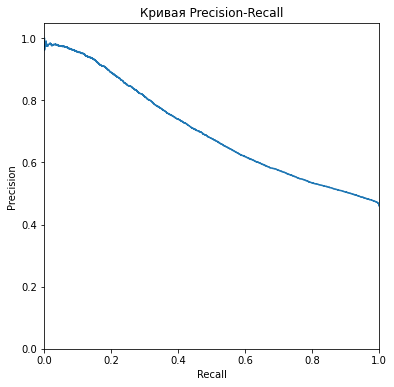

In [55]:
# выведем на экран матрицу ошибок
matrix = confusion_matrix(y_test, predictions_test)
display(matrix)
# рассчитаем вероятности
probabilities = model_test.predict_proba(X_test_new)
precision, recall, thresholds = precision_recall_curve(y_test, probabilities[:, 1])
# построим pr кривую
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

### ROC кривая

'AUC-ROC для модели CatBoostClassifier:'

0.6483437344462016

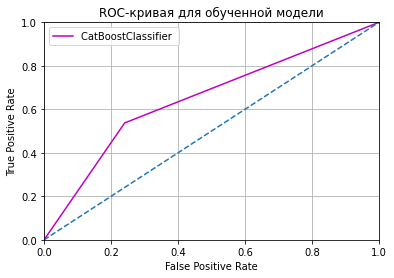

In [56]:
# рассчитаем auc_roc
auc_roc = roc_auc_score(y_test, predictions_test)
# посчитаем площадь под кривой
display('AUC-ROC для модели CatBoostClassifier:', auc_roc)
# рассчитаем значения FPR, TPR и порога
fpr, tpr, thresholds = roc_curve(y_test, predictions_test) 
# построим график с сеткой
plt.figure()
plt.grid(True)
plt.plot(fpr, tpr, color='m')
# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
# установим границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
# подшишем оси
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# укажем заголовок
plt.title('ROC-кривая для обученной модели')
plt.legend(['CatBoostClassifier '])
plt.show()

### Наиболее влияющие признаки на наличие ДТП

Признаками наиболее влияющими на ДТП являются:
- Погода, признак `weather_1`
- Освещенность, признак `lighting`
- Уровень трезвости, признак `party_sobriety`
- Наличие принятых лекарств, признак `party_drug_physical`

#### Определение зависимости тревозвости от количества ДТП

Сформируем запрос и построим столбчатый график для зависимости уровня трезвости от количества ДТП

In [57]:
# сформируем запрос
query_6_4_1 = '''
SELECT *,
       ROUND((sum_fault::numeric / cnt) * 100, 0) AS percentage
FROM
(SELECT p.party_sobriety AS type_sobriety,
       SUM(p.at_fault) AS sum_fault,
       COUNT(p.at_fault) AS cnt
FROM parties AS p
GROUP BY p.party_sobriety) AS temp;
'''
# выведем как таблицу
df_6_4_1 = pd.read_sql_query(query_6_4_1, con=engine) 
display(df_6_4_1)

,type_sobriety,sum_fault,cnt,percentage
0,"had been drinking, impairment unknown",17052,21419,80.0
1,"had been drinking, not under influence",11944,17650,68.0
2,"had been drinking, under influence",105946,112413,94.0
3,had not been drinking,928820,2124727,44.0
4,impairment unknown,182724,232901,78.0
5,not applicable,12801,169343,8.0
6,None,28840,73955,39.0


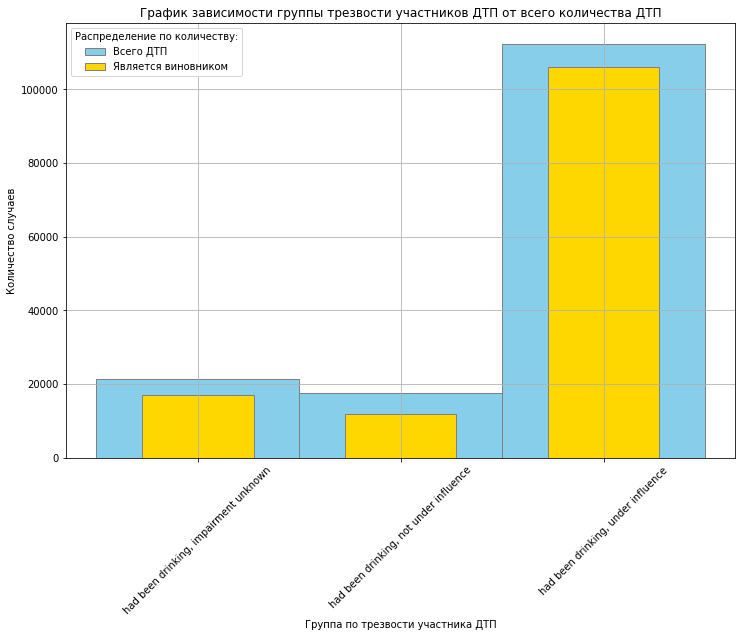

In [58]:
# построение графика 
df_6_4_1['type_sobriety'] = df_6_4_1['type_sobriety'].astype('str')
fig1, ax1 = plt.subplots()
# график построен для наглядности только для групп со значением had been drinking
ax1.bar(df_6_4_1.type_sobriety[0:3], df_6_4_1.cnt[0:3], color = 'skyblue', edgecolor = 'grey', width = 1, label = 'Всего ДТП')
ax1.bar(df_6_4_1.type_sobriety[0:3], df_6_4_1.sum_fault[0:3], color = 'gold', edgecolor = 'grey', width = 0.55, label = 'Является виновником')
fig1.set_figwidth(12)
fig1.set_figheight(8)
ax1.set_xlabel('Группа по трезвости участника ДТП')
ax1.set_ylabel('Количество случаев')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='Распределение по количеству:')
plt.title('График зависимости группы трезвости участников ДТП от всего количества ДТП')
plt.show()

#### Вывод

Из графика можно заметить, что от 68% до 94% случаев, при наличии опьянения - ДТП состоится. Это определенно группы риска, за которыми нужно внимательно наблюдать и сигнализировать о наличии таких водителей.

**Предлагаемое решение**

Перед поездкой, водитель должен зафиксировать количество выдыхаемого воздуха на наличие алкогольного опьянения. Путем отправки результата в специальный чат, приложив фото алкометра с показателем промиле на экране.

#### Определение зависимости наличия принятия лекарств от количества ДТП

Сформируем запрос и построим столбчатый график для зависимости наличия принятия лекарств от количества ДТП

In [59]:
# сформируем запрос
query_6_4_2 = '''
SELECT *,
       ROUND((sum_fault::numeric / cnt) * 100, 0) AS percentage
FROM
(SELECT p.party_drug_physical AS type_drug,
       SUM(p.at_fault) AS sum_fault,
       COUNT(p.at_fault) AS cnt
FROM parties AS p
GROUP BY p.party_drug_physical) AS temp;
'''
# выведем как таблицу
df_6_4_2 = pd.read_sql_query(query_6_4_2, con=engine) 
display(df_6_4_2)

,type_drug,sum_fault,cnt,percentage
0,G,182724,232901,78.0
1,impairment - physical,1874,4188,45.0
2,not applicable,12801,169343,8.0
3,sleepy/fatigued,12066,12641,95.0
4,under drug influence,12161,13215,92.0
5,None,1066501,2320120,46.0


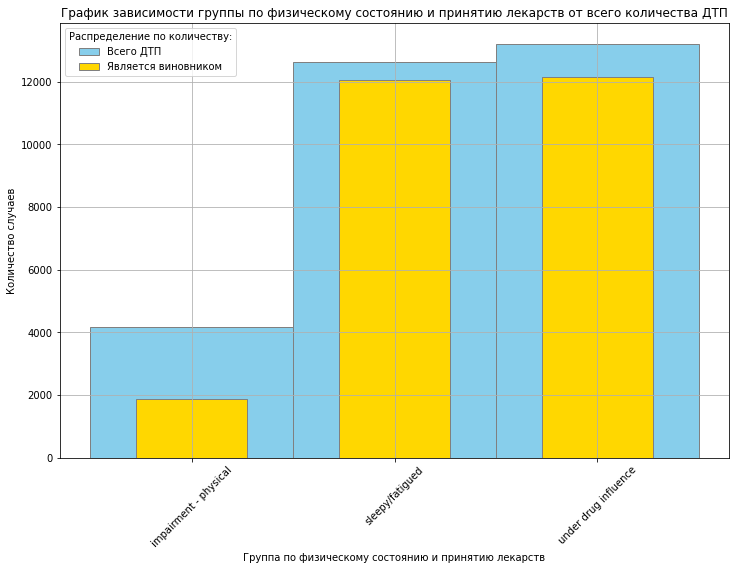

In [60]:
# построение графика 
df_6_4_2['type_drug'] = df_6_4_2['type_drug'].astype('str')
fig2, ax2 = plt.subplots()
# график построен для наглядности, без групп у которых не определено наличие принятия лекарств
ax2.bar(df_6_4_2.type_drug[[1,3,4]], df_6_4_2.cnt[[1,3,4]], color = 'skyblue', edgecolor = 'grey', width = 1, label = 'Всего ДТП')
ax2.bar(df_6_4_2.type_drug[[1,3,4]], df_6_4_2.sum_fault[[1,3,4]], color = 'gold', edgecolor = 'grey', width = 0.55, label = 'Является виновником')
fig2.set_figwidth(12)
fig2.set_figheight(8)
ax2.set_xlabel('Группа по физическому состоянию и принятию лекарств')
ax2.set_ylabel('Количество случаев')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='Распределение по количеству:')
plt.title('График зависимости группы по физическому состоянию и принятию лекарств от всего количества ДТП')
plt.show()

#### Вывод

Из графика можно заметить, что от 45% до 95% случаев, при наличии у водителя физической усталости или у находящихся под действием лекарств, приведет к ДТП. Это определенно группы риска, за которыми нужно внимательно наблюдать и сигнализировать о наличии таких водителей.

**Предлагаемое решение**

Перед поездкой, водитель должен указать в анкете приложения находится ли он под действием лекарств, а также во избежание наличия усталости можно можно раз в 1-2 часа направлять уведомление о том что нужно сделать перерыв, а по истечении непрерывных 8 часов в дороге удаленно предупреждать за 15 минут и заглушить двигатель на 20 минут.